In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/NVL Historical Data 1_6.csv')

In [3]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 4s 86ms/step - loss: 0.0934 - val_loss: 0.0458
Epoch 2/100
16/16 [==============================] - 1s 50ms/step - loss: 0.0154 - val_loss: 0.0160
Epoch 3/100
16/16 [==============================] - 1s 65ms/step - loss: 0.0068 - val_loss: 0.0108
Epoch 4/100
16/16 [==============================] - 1s 85ms/step - loss: 0.0028 - val_loss: 0.0051
Epoch 5/100
16/16 [==============================] - 1s 92ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 6/100
16/16 [==============================] - 2s 96ms/step - loss: 4.2279e-04 - val_loss: 4.4171e-04
Epoch 7/100
16/16 [==============================] - 1s 59ms/step - loss: 3.1512e-04 - val_loss: 3.4520e-04
Epoch 8/100
16/16 [==============================] - 1s 52ms/step - loss: 2.9904e-04 - val_loss: 3.0783e-04
Epoch 9/100
16/16 [==============================] - 1s 52ms/step - loss: 2.8622e-04 - val_loss: 3.5418e-04
Epoch 10/100
16/16 [==============================] - 1s 52ms/step -

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

12/12 [==============================] - 0s 11ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 15864.56314318515


In [14]:
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_pred, ytest)
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))*100
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing MAPE: 99.99955392511654
Testing MAE: 15579.187161680102


In [15]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.04593809321522713], [0.04439031705260277], [0.04272092878818512], [0.040999382734298706], [0.03925100341439247], [0.03748490661382675], [0.0357050895690918], [0.03391386196017265], [0.032112639397382736], [0.030302420258522034], [0.02848382294178009], [0.026657266542315483], [0.02482304722070694], [0.02298136055469513], [0.021132346242666245], [0.019276095554232597], [0.017412710934877396], [0.015542261302471161], [0.013664795085787773], [0.011780377477407455], [0.009889056906104088], [0.007990898564457893], [0.006085944827646017], [0.004174254834651947], [0.0022558702621608973], [0.00033085839822888374], [-0.001600729301571846], [-0.003538843709975481], [-0.0054834079928696156], [-0.007434386294335127], [-0.009391700848937035], [-0.011355297639966011], [-0.013325117528438568], [-0.015301082283258438], [-0.01728314533829689], [-0.019271226599812508], [-0.02126525714993477], [-0.0232651736587286], [-0.02527090348303318], [-0.027282368391752243], [-0.029299501329660416], [-0.03132221

In [16]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[14022.25246246],
       [13895.15527509],
       [13758.07178837],
       [13616.70531261],
       [13473.13539638],
       [13328.1105915 ],
       [13181.95913506],
       [13034.87068872],
       [12886.96149676],
       [12738.31354195],
       [12588.97760469],
       [12438.98809939],
       [12288.36934558],
       [12137.13740331],
       [11985.30374406],
       [11832.87586253],
       [11679.86217113],
       [11526.26832911],
       [11372.09831326],
       [11217.35747693],
       [11062.0497969 ],
       [10906.18062652],
       [10749.75344547],
       [10592.77311   ],
       [10435.24304245],
       [10277.16876823],
       [10118.55451267],
       [ 9959.40430991],
       [ 9799.72446926],
       [ 9639.51793505],
       [ 9478.79109309],
       [ 9317.548379  ],
       [ 9155.79464903],
       [ 8993.53632723],
       [ 8830.7772374 ],
       [ 8667.52395653],
       [ 8503.78214388],
       [ 8339.55699984],
       [ 8174.85448959],
       [ 8009.68103714],


In [17]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[:101])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [18]:
print(y_pred_with_test_data.shape)
test_data.shape

(480,)


(480, 1)

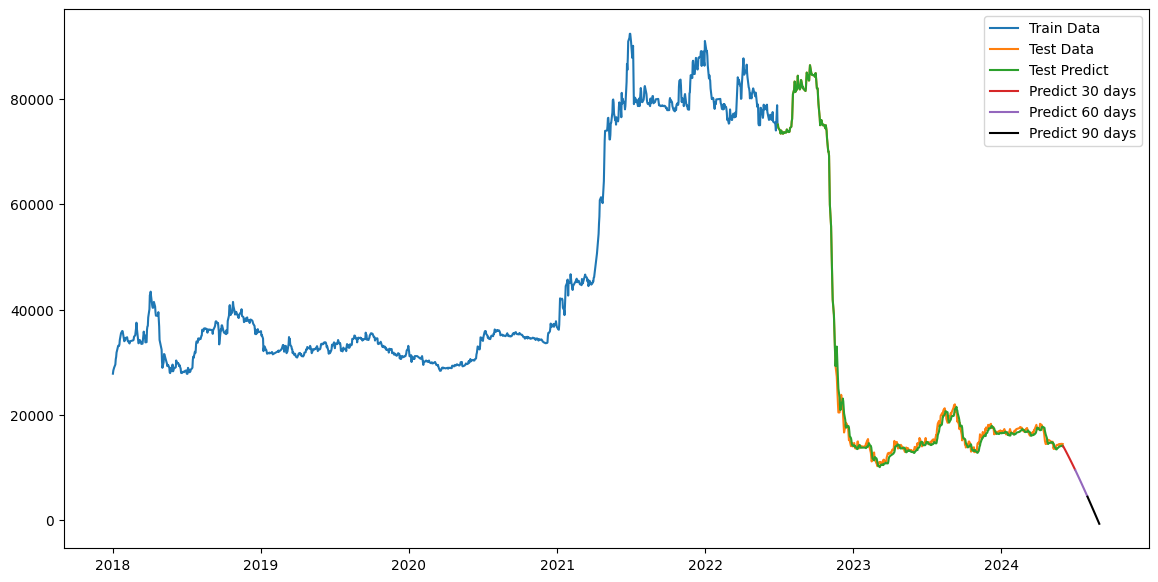

In [19]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred_with_test_data)], y_pred_with_test_data, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=30)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=30)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[30:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[60:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()